In [26]:
import glob
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np


_ = plt.set_cmap("gray")


<Figure size 432x288 with 0 Axes>

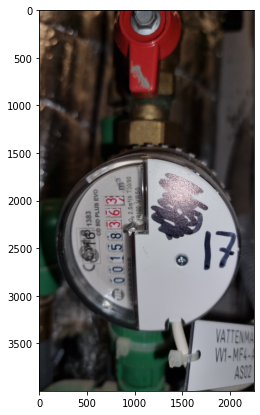

In [27]:
img = cv.imread("img/51_A1002__20220113_233833.jpg")
fig, ax = plt.subplots(1)
fig.set_size_inches(11, 7)
_ = ax.imshow(img[:, :, ::-1])


# Experimentation

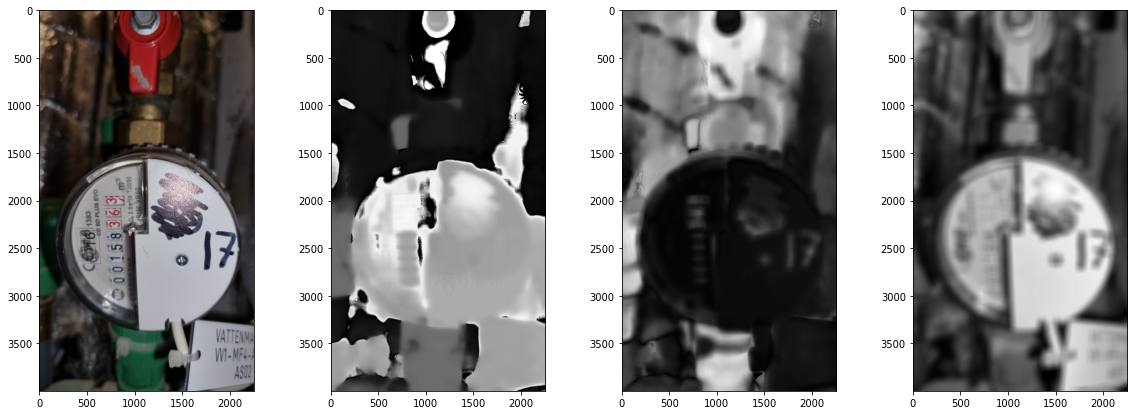

In [28]:
k = 91
b_img = cv.GaussianBlur(img, (k, k), 500)
img_HSV = cv.cvtColor(b_img, cv.COLOR_BGR2HSV_FULL)

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(20, 7)
_ = ax[0].imshow(img[:, :, ::-1])
_ = ax[1].imshow(img_HSV[:, :, 0])
_ = ax[2].imshow(img_HSV[:, :, 1])
_ = ax[3].imshow(img_HSV[:, :, 2])


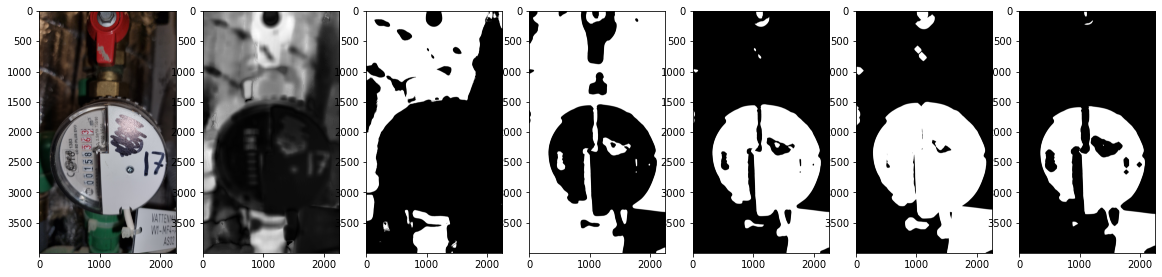

In [29]:
k = 5
b_img_HSV = cv.GaussianBlur(img_HSV, (k, k), 0)
hue = b_img_HSV[:, :, 0]

ret, thresh1 = cv.threshold(
    b_img_HSV[:, :, 1], 0, 255, cv.THRESH_OTSU | cv.THRESH_BINARY
)
ret, thresh2 = cv.threshold(
    b_img_HSV[:, :, 2], 0, 255, cv.THRESH_OTSU | cv.THRESH_BINARY_INV
)
out_img = cv.bitwise_not(thresh2 | thresh1)

rect_kernel = cv.getStructuringElement(cv.MORPH_DILATE, (17, 17))
dilation = cv.dilate(out_img, rect_kernel, iterations=5)
erode = cv.erode(out_img, rect_kernel, iterations=4)

fig, ax = plt.subplots(1, 7)
fig.set_size_inches(20, 7)
_ = ax[0].imshow(img[:, :, ::-1])
_ = ax[1].imshow(img_HSV[:, :, 1])
_ = ax[2].imshow(thresh1)
_ = ax[3].imshow(thresh2)
_ = ax[4].imshow(out_img)
_ = ax[5].imshow(dilation)
_ = ax[6].imshow(erode)


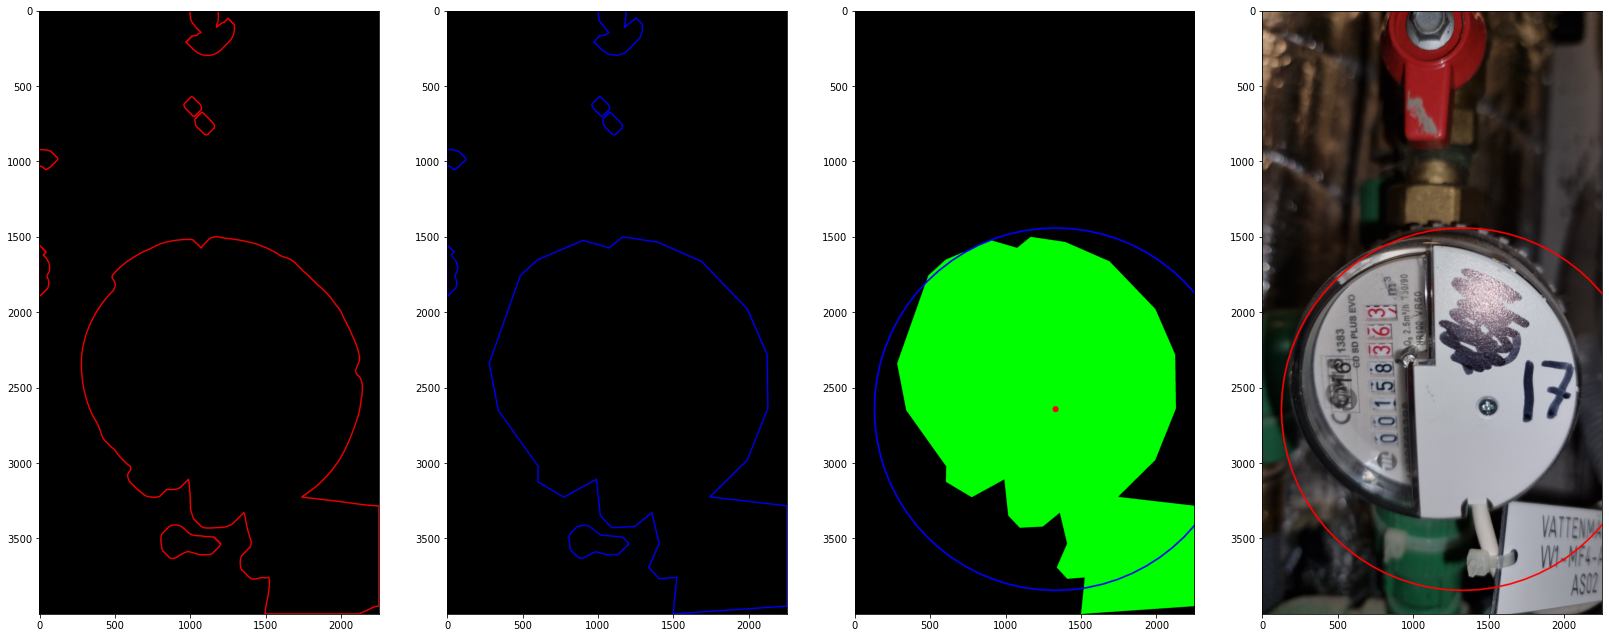

In [32]:
def approximate(cntr, epsilon=0.1):
    peri = cv.arcLength(cntr, True)
    return cv.approxPolyDP(cntr, epsilon * peri, True)

contours, _ = cv.findContours(dilation, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
black = np.zeros(img.shape)
one = cv.drawContours(black.copy(), contours, -1, (1, 0, 0), 7)

approx = [approximate(x, 0.005) for x in contours]

two = black.copy()
for app in approx:
    cv.drawContours(two, [app], -1, (0, 0, 1), 7)

fig, ax = plt.subplots(1, 4)
fig.set_size_inches((7 * 4, 24))

biggest = sorted(approx, key=cv.contourArea)[-1]
three = cv.drawContours(black.copy(), [biggest], -1, (0, 1, 0), -1)


M = cv.moments(biggest)
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])

cv.circle(three, (cx,cy), 20, (1,0,0), -1)
cv.circle(three, (cx,cy), 1200, (0,0,1), 10)
selection = cv.circle(img.copy(), (cx,cy), 1200, (0,0,255), 10)

ax[0].imshow(one)
ax[1].imshow(two)
ax[2].imshow(three)
ax[3].imshow(selection[:,:,::-1])

# Contours


## Prepossessing

In [33]:
def preProssessing(img, kernel_size=5):
    img_HSV = cv.cvtColor(img, cv.COLOR_BGR2HSV_FULL)

    b_img_HSV = cv.GaussianBlur(img_HSV, (kernel_size, kernel_size), 0)

    _, thresh1 = cv.threshold(
        b_img_HSV[:, :, 1], 0, 255, cv.THRESH_OTSU | cv.THRESH_BINARY
    )
    _, thresh2 = cv.threshold(
        b_img_HSV[:, :, 2], 0, 255, cv.THRESH_OTSU | cv.THRESH_BINARY_INV
    )
    
    out_img = cv.bitwise_not(thresh2 | thresh1)

    rect_kernel = cv.getStructuringElement(
        cv.MORPH_DILATE, (kernel_size * 3, kernel_size * 3)
    )
    return cv.dilate(out_img, rect_kernel, iterations=5)


## Selection

In [34]:
def approximate(cntr, epsilon=0.1):
    peri = cv.arcLength(cntr, True)
    return cv.approxPolyDP(cntr, epsilon * peri, True)

def get_biggest_contour(img, mode=cv.RETR_EXTERNAL, method=cv.CHAIN_APPROX_NONE, epsilon=0.005):
    contours, _ = cv.findContours(img, mode, method)
    approx = [approximate(x, epsilon) for x in contours]
    return sorted(approx, key=cv.contourArea)[-1]
    

def get_selection(img, contour, r=1200):
    M = cv.moments(contour)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    black = np.zeros(img.shape[:-1])
    return cv.circle(black, (cx,cy), r, 255, -1)



## Test

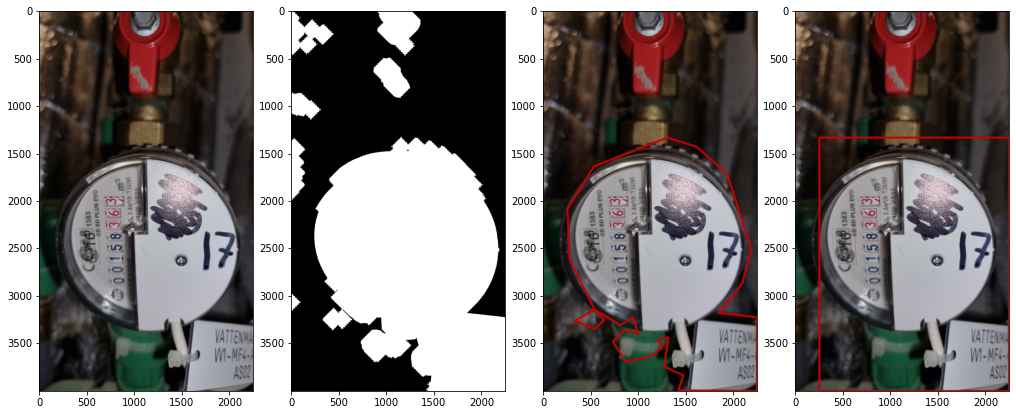

In [35]:
## test
preProssesd = preProssessing(img, 13)
biggest = get_biggest_contour(preProssesd)
mask_sel = get_selection(img, biggest)

fig, ax = plt.subplots(1, 4)
fig.set_constrained_layout(True)
fig.set_size_inches(14, 14)

x1, y1, w, h = cv.boundingRect(biggest)

selection = cv.rectangle(img.copy(), pt1=(x1,y1), pt2=(x1+w,y1+h), color=(0,0,200), thickness=20)

ax[0].imshow(img[:,:,::-1])
ax[1].imshow(preProssesd)
ax[2].imshow(cv.drawContours(img.copy(), [biggest],-1, (0,0,200), 20)[:,:,::-1])
ax[3].imshow(selection[:,:,::-1])


In [80]:
images = [cv.imread(f) for f in glob.glob('img/*.jpg')]

In [81]:
def process_image(image):
    img = image.copy()
    preProssesd = preProssessing(img, 31)
    biggest = get_biggest_contour(preProssesd)
    cv.drawContours(img, [biggest], -1, (200,0,0), 20)
    cv.drawContours(img, [biggest], -1, (0,0,200), -1)
    return img
    # x1, y1, w, h = cv.boundingRect(biggest)
    # return img[y1 : y1 + h, x1 : x1 + w, :]
    # return cv.rectangle(img, pt1=(x1,y1), pt2=(x1+w,y1+h), color=(0,0,200), thickness=20)


In [82]:
processed_images = [process_image(i) for i in images]


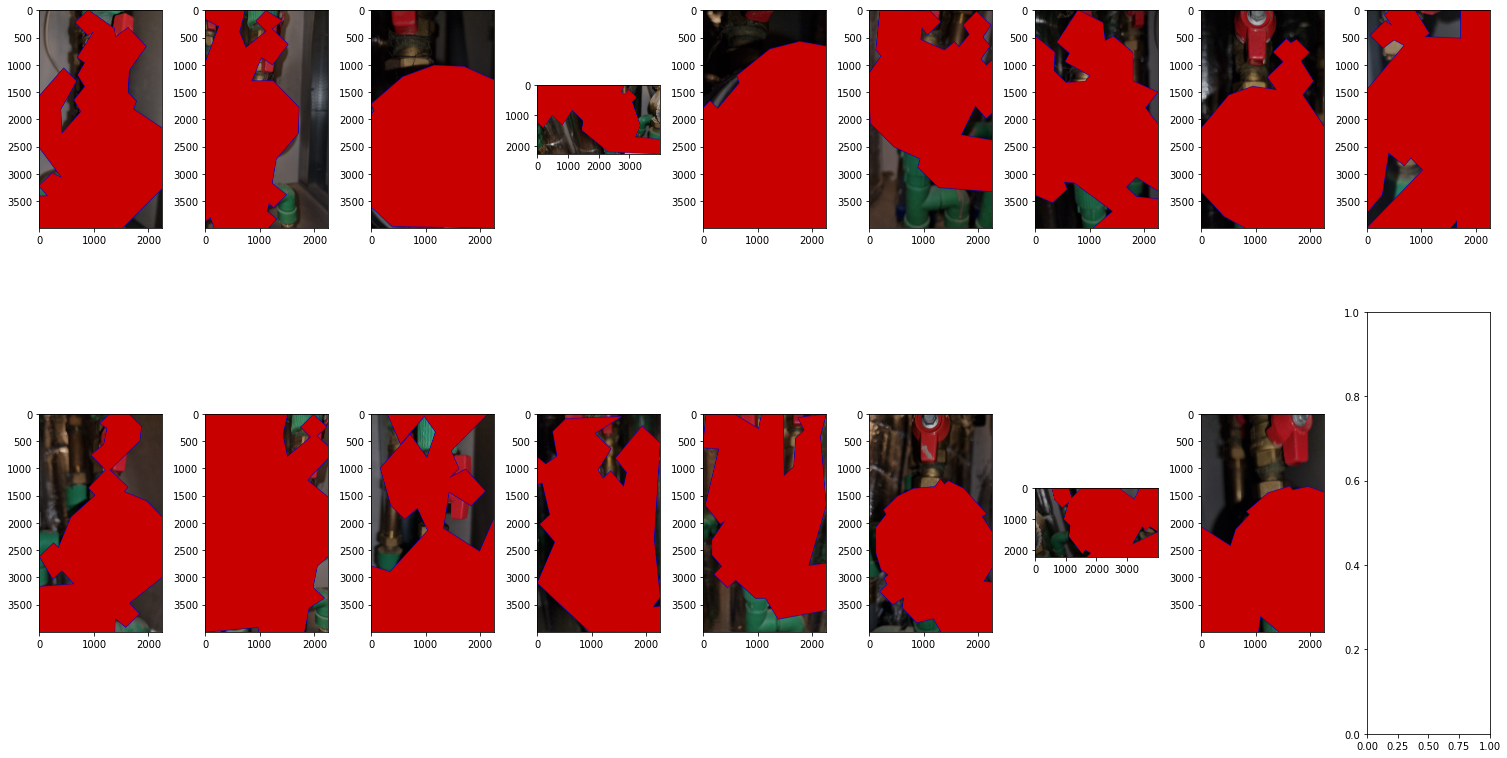

In [84]:

fig, ax = plt.subplots(2,9)
fig.set_size_inches(21,12)
fig.set_tight_layout(True)


for ix, image in enumerate(processed_images):
  ax[ix//9, ix%9].imshow(image[:,:,::-1])